In [ ]:
# Parameters, literals
# Then reading
# Split preprocessing and working code

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import pandas as pd
from sklearn.decomposition import PCA
from imutils.object_detection import non_max_suppression
import time
import cv2
import pytesseract
from os import path
from IPython.display import clear_output
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import linear_model


In [ ]:
# Cells 1 and 2 perform some PCA pre analysis

numImages=len(os.listdir("images/"))

fig = plt.figure(figsize=(7,7))
count = 1
OneDData=np.empty((1, 270000))
ThreeDData=np.empty((300,300,3))

for file in os.listdir("images/"):
    ax = fig.add_subplot(5,5,count)
    img = Image.open("images/"+file)
    newsize=(300,300)
    imgresize = img.resize(newsize)
    photo = np.array(list(imgresize.getdata()), dtype="uint8")
    photo = np.resize(photo, (300,300,3))
    plt.imshow(photo)
    plt.axis('off')
    ThreeDData = np.concatenate((ThreeDData, photo), axis=0)
    OneDData = np.concatenate((OneDData, np.resize(photo, (1,270000))), axis=0)
    count+=1
    

In [ ]:
numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(OneDData)
colors=["red", "red","red","red","red","red","red","red","red","red","red","red","red","red","red","red","red","blue","red",]
projected = pca.transform(OneDData)
projected = pd.DataFrame(projected, columns=['pc1', 'pc2'], index=range(1, numImages+2))
projected.plot(kind='scatter', x='pc1', y='pc2', c=colors)
projected

In [9]:
# This cell performs text barrier production
for file in os.listdir("images/"):
    imagepath = "images/"+file
    minconfidence = 0.5
    width = 320
    height = 320

    image = cv2.imread(imagepath)
    orig = image.copy()
    (H, W) = image.shape[:2]
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]


    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]


    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()
    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))



    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < minconfidence:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        #roi = image[startY:endY, startX:endX]
    # show the output image

    cv2.imshow(file, orig)
    cv2.waitKey(0)

[INFO] text detection took 0.717556 seconds


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [7]:
# Preprocessing for tesseract
data = pd.read_excel("VaxPics.xlsx")
data.head()

,Pro/Anti,Image,Source
0,Pro,vlhzk7bbfjf41,Reddit
1,Anti,c8xcc7ohvef41,Reddit
2,Anti,safe_image,Facebook
3,Anti,polio-Project180-Meme-800,stopmandatoryvaccination
4,Anti,Cook-300x600-a,stopmandatoryvaccination


Images/vlhzk7bbfjf41.jpg


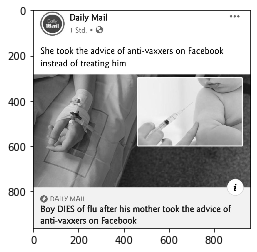

Daily Mail eee
1 Std. @

She took the advice of anti-vaxxers on Facebook
instead of treating him

 

O DAILY MAIL
Boy DIES of flu after his mother took the advice of
anti-vaxxers on Facebook
Images/c8xcc7ohvef41.jpg


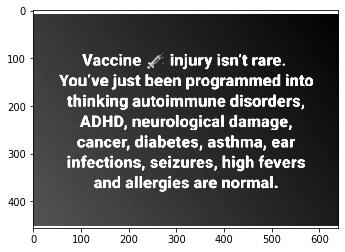

Vaccine ¢ injury isn't rare.
You've just been programmed into
thinking autoimmune disorders,
ADHD, neurological damage,
cancer, diabetes, asthma, ear
infections, seizures, high fevers
and allergies are normal.
Images/safe_image.jpg


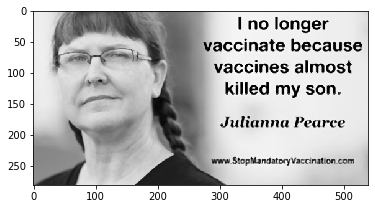

I no longer
vaccinate because
vaccines almost

killed my son.

Julianna Pearce

www. Stop Mandatory Vaccination. com
Images/polio-Project180-Meme-800.jpg


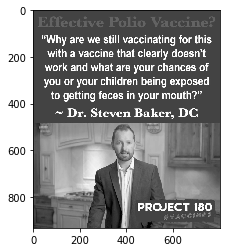

“Why are we still vaccinating for this
with a vaccine that clearly doesn’t
work and what are your chances of
you or your children being exposed
to getting feces in your mouth?”

~ Dr. Steven Baker, DC
Images/Cook-300x600-a.jpg


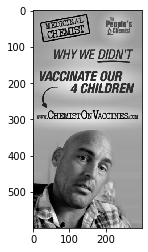

seuss) ales
WHY WE DIDN'T

VACCINATE OUR
4 CHILDREN

vn CHEMISTON VACCINES com
Images/WeDontVaccinate_300x189-1.jpg


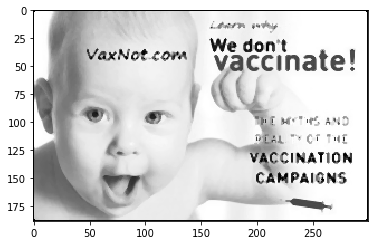

Lewen why
We don't
anor cer
Images/82324209_2514442891988113_703046181684510720_n.jpg


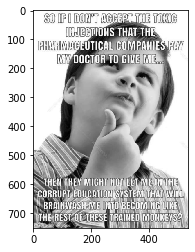


Images/82802449_2506582829440786_1093564893367369728_n.png


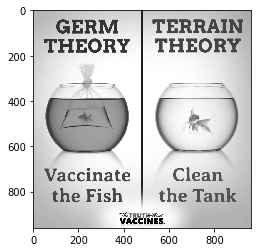

GERM _ | TERRAIN
THEORY | THEORY

Vaccinate Clean
the Fish the Tank

TheT RUT Meat
VACCI NES.
Images/82822219_2479706145461788_6153366273083310080_n.png


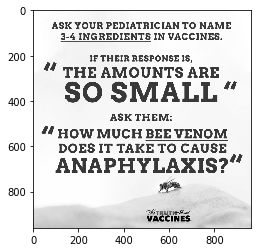

ASK YOUR PEDIATRICIAN TO NAME
3-4 INGREDIENTS IN VACCINES.

IF THEIR RESPONSE IS,

“4 THE AMOUNTS ARE

SO SMALL”

ASK THEM:

44 ti0W MUCH BEE VENOM
DOES IT TAKE TO CAUSE

ANAPHYLAXIS?”

The TRUTH cut
VACCINES.
Images/71184354_2278856202213451_963905281014628352_n.png


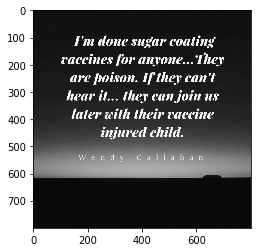

MEM LES
vaccines for anyone... They
Te EX MLA
hear it... they can join us
later with their vaccine
Teme
Images/30712053_1518469638252115_4171023889981243392_n.png


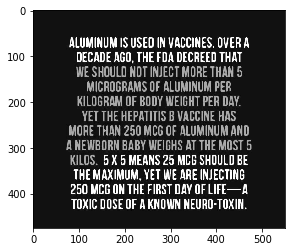

ALUMINUM IS USEO IN VACCINES. OVER A
See Te
Pa

MICROGRAMS OF ALUMINUM PER
SO a eT aes
MUNA HAL ALN
ee a Te ELLY
A NEWBORN BABY WEIGHS AT THE MOST 5
LR CL Sra 3
THE MAXIMUM, YET WE ARE INJECTING
250 MCG ON THE FIRST DAY OF LIFE—A
OHS SCS att
Images/12801256_920675384717801_5460041518225695168_n.jpg


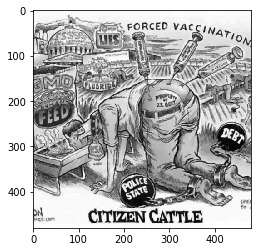

ED VAC CIN
RS
FO

a
Images/81808346_704924869915102_8252834639140356096_n.jpg


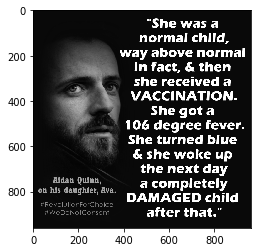

"She was a
normal child,
way above normal

— in fact, & then
2 she received a
. VACCINATION.

? x She gota

106 degree fever.
™) She turned blue
& she woke up
ae ala eae FY
‘ an Quinn, F completely
en is deughtes "DAMAGED child
re Doel Sfeuisey after that."
Images/13308216_276941722652326_6728547561635306411_o.jpg


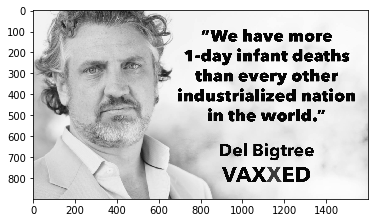

“We have more
1-day infant deaths
than every other
industrialized nation
in the world.”

Del Bigtree
VAXXED
Images/79917164_2732384440173617_3763435612464480256_n.jpg


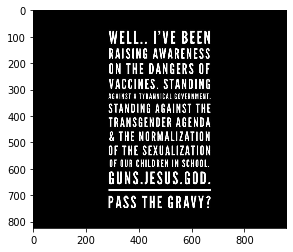

WELL.. I'VE BEEN
RAISING AWARENESS
RS ST
VACCINES. STANDING

NTINEMLCC ee
OUT UA 3
UN ea)
Pe
a ULL
OF OUR CHILDREN IN SCHOOL.

CE Le
SU
Images/79223155_2704897662922295_8371730496513638400_n.jpg


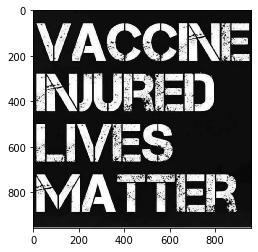

VACCINE
Nee
LIVES
MATTER
Images/76996992_2659451020800293_7908310169589645312_n.jpg


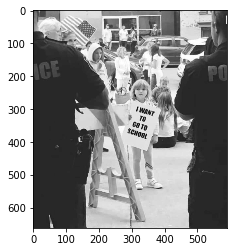


Images/78095364_2688988467789237_6756724837898518528_o.jpg


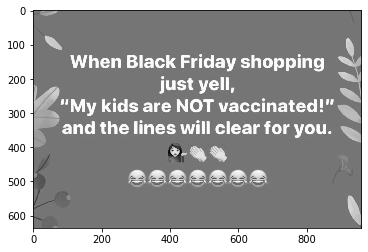

When Black Friday shopping ‘b

v just yell, ~
| 0) kids are NOT vaccinated!” ON
.

and the lines will clear for you.

%-Qe
Ve VV VV V8

|
Images/CCFJouYUAAAa8XB.jpg


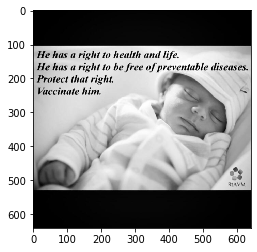

He has a right to health and life.

He has a right to be free of preventable diseases.
Protect that right.

Vaccinate him. ,
Images/CDFRivDWYAAGMBu.jpg


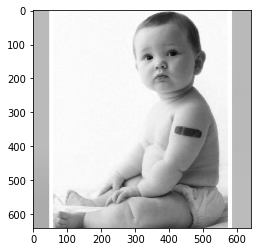


Images/D2l9PHFX0AAbLoe.png


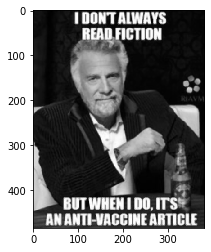


Images/DoBDDyAXgAA85AC.jpg


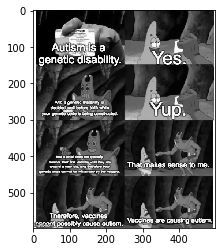

fi
ria bit oe
Images/CQwghklWoAAneVs.jpg


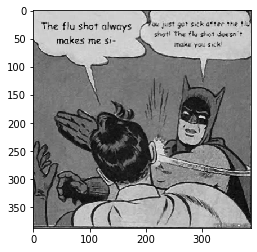

fou just got suck after the thy
shot! The flu shot doesn't
make you sick!

The flu shot always
makes me si-
Images/DqNoqnOX0AA4aLE.jpg


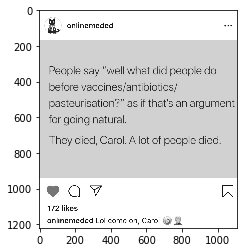

a onlinemeded

People say “well what did people do
before vaccines/antibiotics/
pasteurisation?” as if that's an argument
for going natural.

They died, Carol. A lot of people died.

9QaV W

172 likes
onlinemeded Lol come on, Carol @ {
Images/D8v94VAU8AAu9sk.jpg


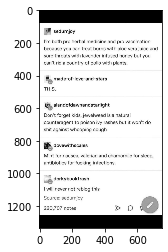

wv sedumjoy

I’m both pro herbal medicine and pro vaccination
because you can treat burns with aloe vera juice and
sore throats with lavender infused honey but you
can’t rid a country of polio with plants.

™.. made-of-love-and-stars
CS

THIS.

@., alandofdawnandstarlight

Don’t forget kids, jewelweed is a natural
counteragent to poison ivy rashes but it won’t do
shit against whooping cough

i. dovewithscales

Mint for nausea, valerian and chamomile for sleep,
antibiotics for fucking infections.

ge dorkybooktrash

| will never not reblog this
Source: sedumjoy

220,707 notes > O

+2
Images/Diqs-3gWAAAj7zY.jpg


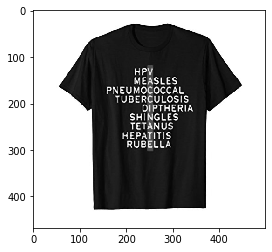

HPV
Waa ay
PNEUMOCOCCAL
TUBERCULOSIS
eA aIEY

SHINGLES
TETANUS
HEPATITIS
RUBELLA
Images/DJy-9m-UIAA2XbN.jpg


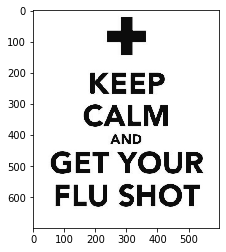

ct

KEEP
CALM

AND

GET YOUR
FLU SHOT
Images/EQo7qoDXYAA-Z7j.jpg


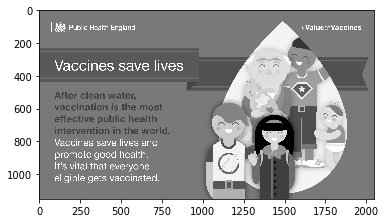

allele a =-unaare lta! #Valuecf Vaccines

Vaccines save lives

Vaccines save lives and S

promote good health.
It’s vital that everyone
eligible gets vaccinated.
Images/EQlxzKwWsAAM4vG.jpg


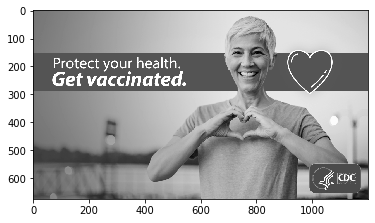

Protect your health.
eT alee een
Images/EQthffcU8AIoDx_.jpg


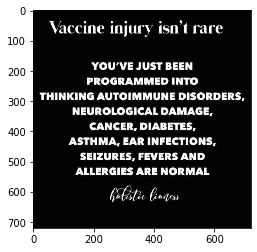

Vaccine injury isn’t rare

YOU'VE JUST BEEN
PROGRAMMED INTO
THINKING AUTOIMMUNE DISORDERS,
NEUROLOGICAL DAMAGE,
CANCER, DIABETES,
ASTHMA, EAR INFECTIONS,
SEIZURES, FEVERS AND
ALLERGIES ARE NORMAL

hs eae (i a eed
Images/ERB0O4bX0AAqT25.jpg


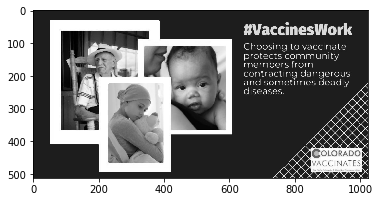

#VaccinesWork

Choosing to vaccinate
protects community
members from
contracting dangerous
and sometimes deadly
diseases.
Images/EQqrsCCUYAAkdB7.jpg


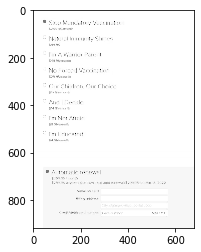

® Stop Mandatory Vaccination!

$299 F5arontn

© Natural Immunity Shines
sos

© im A Warrior Parent

$49 92/montn

© No forced Vaccination

$279.94/monm

> Our Children, Our Choice

$19 94month

> And | Decide

$4 O4mont

© |'m Not Atraid

$9.9 month

© I'm | ducated

$4 9 /montn

® Automatic renewal
$299-95 / month
$299 95 payment due now, Next auto TeNewal ($299 95) on Mar 13, 2020

Name on cata

Bating adress,

Crecildebil card pumber Catd number MMF YY
Images/EQhSlizXsAAgbou.jpg


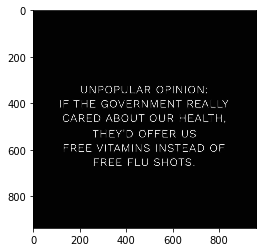

UNPOPULAR OPINION:

IF THE GOVERNMENT REALLY
CARED ABOUT OUR HEALTH,
THEY’D OFFER US
FREE VITAMINS INSTEAD OF
FREE FLU SHOTS.
Images/EQvV5rDWAAAtUdk.jpg


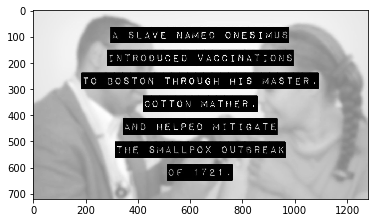

A SLAVE NAMED ONESIMUS

INTRODUCED VACCINATIONS

TO BOSTON THROUGH HIS MASTER,

COTTON MATHER,
ANO HELPED MITIGATE

THE SMALLPOX OUTBREAK

OF 1721.
Images/EQquou1WkAkoxI5.jpg


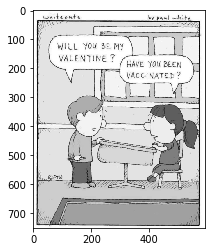

whiteouts by paul whit

Li
WILL YOU BE My ees)

VALENTINE ?
Images/EQrlcmqWAAMlm0y.png


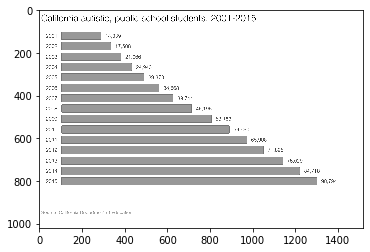

California autistic, public school students, 2001-2015

2001
2002

14,039
17,508

2003
2004
2005

21,066
24,943
29,370

2006
2007
2008
2009

34,668
39,711

46,196

53,183
2010

59,690
2011

65,908
2012

71,825
2013

78,629
2014

84,718
2015

90,794

Source: California Department of Education
Images/EQVo367W4AAvQMe.jpg


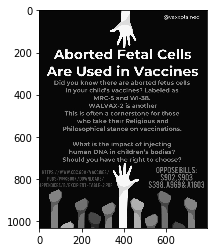

@vaxxplained

Aborted Fetal Cells
Are Used in Vaccines

Did you know there are aborted fetus cells
in your child’s vaccines? Labeled as
MRC-5 and WI-38.

WALVAX-2 is another
This is often a cornerstone for those
who take their Religious and
Philosophical stance on vaccinations.

What is the impact of injecting

human DNA in children’s bodies?
Should you have the right to choose?

OPPOSEBILLS:
$902,903
SPARSE Zvi)

he
Images/EPmI1xwW4AA0SYd.jpg


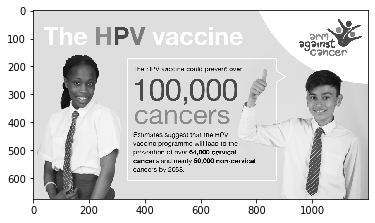

e@
HPV mene’
concer

The HPV vaccine could prevent over

100,000 0
cancers § ow
/

Estimates suggest that the HPV

vaccine programme will lead to the
prevention of over 64,000 cervical
cancers and nearly 50,000 non-cervical
cancers by 2058.
Images/EPWsh0qX4AAOW1s.jpg


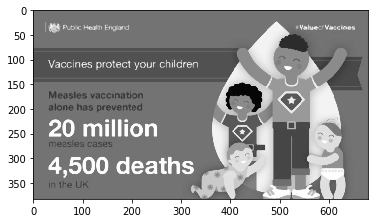

eee a) Deh cary

  
   

Vaccines protect your children

 

 

 

 

20 million
4,500 deaths


In [3]:
# Pytesseract OCR, shows each image and the text read from it using pytesseract
words = []
for file in data["Image"]:
    imagepath = "Images/"+file+".png"
    if not path.exists(imagepath):
        imagepath = "Images/"+file+".jpg"
    width = 320
    height = 320
    print(imagepath)

    image = cv2.imread(imagepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    newimage = "greyimage.png"
    orig = image.copy()
    (H, W) = image.shape[:2]
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)
    # resize the image and grab the new image dimensions
    #image = cv2.resize(image, (newW, newH))
    cv2.imwrite(newimage, gray)
    text = pytesseract.image_to_string(Image.open(newimage))
    words.append(text)
    plt.figure()
    plt.imshow(gray, cmap='gray')
    plt.show()
    print(text)
data["Words"] = pd.Series(words)

In [4]:
data.head()

,Pro/Anti,Image,Source,Words
0,Pro,vlhzk7bbfjf41,Reddit,Daily Mail eee\n1 Std. @\n\nShe took the advic...
1,Anti,c8xcc7ohvef41,Reddit,Vaccine ¢ injury isn't rare.\nYou've just been...
2,Anti,safe_image,Facebook,I no longer\nvaccinate because\nvaccines almos...
3,Anti,polio-Project180-Meme-800,stopmandatoryvaccination,“Why are we still vaccinating for this\nwith a...
4,Anti,Cook-300x600-a,stopmandatoryvaccination,seuss) ales\nWHY WE DIDN'T\n\nVACCINATE OUR\n4...


In [11]:
words = []
label = []
filenames = []
# Pro pool
for file in os.listdir("images/nonanti_pool_63432"):
    start, end = os.path.splitext(file)
    if end == ".txt":
        os.remove("images/nonanti_pool_63432/"+file) # Remove text files from data folder
    else:
        imagepath = "images/nonanti_pool_63432/"+file
        image = cv2.imread(imagepath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 3)
        newimage = "greyimage.png"
        cv2.imwrite(newimage, gray)
        text = pytesseract.image_to_string(Image.open(newimage))
        #plt.figure()
        #plt.imshow(gray, cmap='gray')
        #plt.show()
        #print(text)
        if text != "":
            words.append(text)
            label.append("Pro")
            filenames.append(file)

# Anti pool
for file in os.listdir("images/anti_pool_61696"):
    start, end = os.path.splitext(file)
    if end == ".txt":
        os.remove("images/anti_pool_61696/"+file) # Remove text files from data folder
    else:
        imagepath = "images/anti_pool_61696/"+file
        image = cv2.imread(imagepath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 3)
        newimage = "greyimage.png"
        cv2.imwrite(newimage, gray)
        text = pytesseract.image_to_string(Image.open(newimage))
        #plt.figure()
        #plt.imshow(gray, cmap='gray')
        #plt.show()
        #print(text)
        if text != "":
            words.append(text)
            label.append("Anti")
            filenames.append(file)
            
realData = pd.DataFrame({"File":filenames, "Text":words, "Class":label})
realData.head()

,File,Text,Class
0,cdcglobal-20170120-514+BPfN66MlEgc+-1.jpg,The world is more\n\nconnected than in\n\nany ...,Pro
1,cdcglobal-20170203-503+BQD_bDngXHk+-1.jpg,FEBRUARY 4\n\nTHE GLOBAL CANCER EPIDEMIC\nCONT...,Pro
2,cdcglobal-20170204-502+BQGBCsaA9We+-1.jpg,As a global public health community we can wor...,Pro
3,cdcglobal-20170322-472+BR8UovohX6R+-1.jpg,OVER 80% OF OUR WASTEWATER\nFLOWS BACK TO NATU...,Pro
4,cdcglobal-20170420-448+BTHGEW6B2hj+-1.jpg,( More than\n\n(m1) 88 0e)\\n\npeople are affe...,Pro


In [3]:
realData.to_csv("RealData.csv")

NameError: name 'realData' is not defined

In [9]:
realData = pd.read_csv("RealData.csv")
realData.head()
realData.shape

(4136, 4)

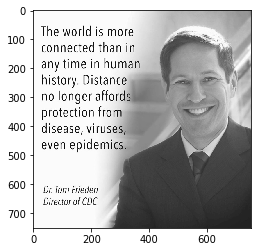

PyTesseract Output: 
The world is more

connected than in

any time in human
history. Distance
no longer affords
protection from
disease, viruses,
even epidemics.

  
  
  
   
  

Dr. Tom Frieden
Director of CDC


In [21]:
file = realData["File"][0]
imagepath = "images/nonanti_pool_63432/"+file
image = cv2.imread(imagepath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 3)
newimage = "greyimage.png"
cv2.imwrite(newimage, gray)
text = pytesseract.image_to_string(Image.open(newimage))
plt.figure()
plt.imshow(gray, cmap='gray')
plt.show()
print("PyTesseract Output: \n" + text)

Max Test Accuracy: 0.7920696324951644


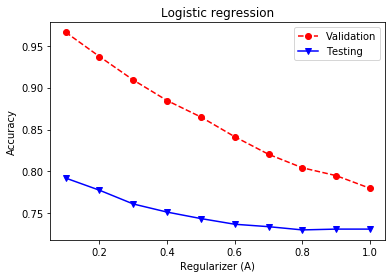

In [11]:
#Multinomial Naive Bayes Classifier
regularizers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
testAcc= np.zeros(len(regularizers))
trainAcc = np.zeros(len(regularizers))
index=0
X = realData["Text"]
Y = realData["Class"]
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state=1)
for A in regularizers:
    text_clf = Pipeline([
         ('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', MultinomialNB(alpha=A))])
    clf = text_clf.fit(trainX, trainY)
    Y_predTrain = text_clf.predict(trainX)
    Y_predTest = text_clf.predict(testX)
    trainAcc[index] = accuracy_score(trainY, Y_predTrain)
    testAcc[index] = accuracy_score(testY, Y_predTest)
    index += 1
plt.plot(regularizers, trainAcc, 'ro--', regularizers, testAcc, 'bv-')
plt.xlabel('Regularizer (A)')
plt.ylabel('Accuracy')
plt.title('Logistic regression')
plt.legend(['Validation','Testing'])
print("Max Test Accuracy:", max(testAcc))

Max Test Accuracy: 0.758220502901354


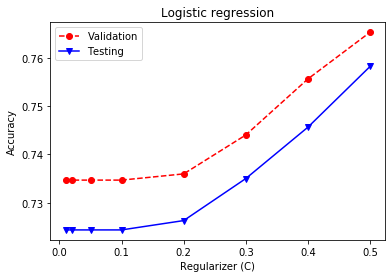

In [9]:
# Logistic Regression
regularizers = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
testAcc= np.zeros(len(regularizers))
trainAcc = np.zeros(len(regularizers))
index=0
X = realData["Text"]
Y = realData["Class"]
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state=1)

for C in regularizers:
    text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', linear_model.LogisticRegression(C=C, penalty='l1', solver='liblinear'))])
    clf = text_clf.fit(trainX, trainY)
    Y_predTrain = text_clf.predict(trainX)
    Y_predTest = text_clf.predict(testX)
    trainAcc[index] = accuracy_score(trainY, Y_predTrain)
    testAcc[index] = accuracy_score(testY, Y_predTest)
    index += 1
plt.plot(regularizers, trainAcc, 'ro--', regularizers, testAcc, 'bv-')
plt.xlabel('Regularizer (C)')
plt.ylabel('Accuracy')
plt.title('Logistic regression')
plt.legend(['Validation','Testing'])
print("Max Test Accuracy:", max(testAcc))

In [10]:
# Code to perform manual pytesseract accuracy test of 100 random images, 50 pro, 50 anti
ProPool = realData[realData["Class"] == "Pro"].sample(50, random_state = 3)
AntiPool = realData[realData["Class"] ==  "Anti"].sample(50, random_state=3)
pool = ProPool.append(AntiPool)
pytext = []

for file in pool["File"]:
    imagepath = "images/nonanti_pool_63432/"+file
    if not path.exists(imagepath):
        imagepath = "images/anti_pool_61696/"+file
    image = cv2.imread(imagepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    newimage = "greyimage.png"
    cv2.imwrite(newimage, gray)
    text = pytesseract.image_to_string(Image.open(newimage))
    #plt.figure(figsize=(10,10))
    #plt.clf()
    #plt.imshow(gray, cmap='gray')
    #plt.show()
    print("PyTesseract Output: \n" + text)
    pytext.append(text)
    #input("Press Enter When Ready")
    clear_output(wait=True)


PyTesseract Output: 
WHEN SOMEONE SAYS THE GOVERNMENT

LIES ABOUT EVERYTHING BUT WOULDN'T
LIE ABOUT THE SHAPE OF THE EARTH


In [11]:
paths = []

for file in pool["File"]:
    imagepath = "images/nonanti_pool_63432/"+file
    if not path.exists(imagepath):
        imagepath = "images/anti_pool_61696/"+file
    paths.append(imagepath)

In [12]:
# Generate file with the manual entered strings and the corresponding pytesseract results
pystrings = pd.read_excel("PyTesseractStringRating.xlsx")
pystrings["TesseractResult"] = pd.Series(pytext)
pystrings["ImagePath"] = pd.Series(paths)
pystrings.head()
pystrings.to_excel("PytesseractStringRatingComplete.xlsx")

In [2]:
data = pd.read_excel("PytesseractStringRatingComplete.xlsx")
ratings = []
for i in range(data["Actual String"].size):
    print("Actual String: ", data["Actual String"][i])
    print("\n")
    print("Pytesseract String: ", data["TesseractResult"][i])
    ratings.append(input("Rating: "))
    clear_output(wait=True)
    
data["Rating"] = pd.Series(ratings)
data.to_excel("PytesseractStringRatingComplete2.xlsx")

Actual String:  Heads up on sb277 there is no grandfather clause in the latest round of amendments None! Line 11 has not been stricken. Future exemptions for new vaccines added to the schedule are only if, which means they do not exist as the law is currently drafted. kil the bill Update from NVIC Oppose sb 277 Eliminates personal belief


Pytesseract String:  HEADS UP on SB277

There is NO Grandfather clause in the latest
round of amendments. None!

Line 11 has NOT been stricken. Future
exemptions for new vaccines added to the
schedule are ONLY IF, which means they do
not exist as the law is currently drafted.

KILL the BILL

UPDATE from NVIC:

OPPOSE SB 277, Eliminates Personal Belief
Rating: e


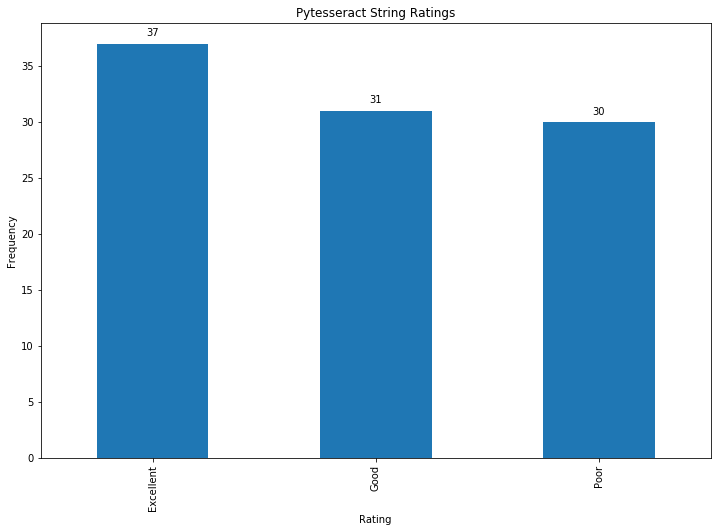

In [17]:
data = pd.read_excel("PytesseractStringRatingComplete2.xlsx")
#data["Rating"].value_counts().plot(kind='bar')

plt.figure(figsize=(12,8))
ax = data["Rating"].value_counts().plot(kind='bar')
labels = data["Rating"].value_counts()
ax.set_title("Pytesseract String Ratings")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
rects = ax.patches
ax.set_xticklabels(["Excellent", "Good", "Poor"])
for rect, labels in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, labels, ha="center", va='bottom')